In [1]:
%env GEOMSTATS_BACKEND=pytorch

env: GEOMSTATS_BACKEND=pytorch


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")  

import os
import numpy as np
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


from scipy.spatial.transform import Rotation
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

from utils.plotting import plot_so3
from foldflow.utils.so3_helpers import norm_SO3, expmap, exp, hat
from utils.so3_cfm import SO3SFM
from utils.optimal_transport import so3_wasserstein as wasserstein
from so3_experiments.models.models import PMLP

from torch.utils.data import DataLoader
from data.datasets import SpecialOrthogonalGroup

from geomstats._backend import _backend_config as _config
_config.DEFAULT_DTYPE = torch.cuda.FloatTensor 

savedir = "models/so3_synthetic"
os.makedirs(savedir, exist_ok=True)

/data/wuhl/anaconda3/envs/foldflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend
INFO: Note: detected 232 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 232 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO: NumExpr defaulting to 16 threads.


In [4]:
# import sys
# sys.path.append("..")  

# import os
# import torch
# import numpy as np
# from einops import rearrange
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# from functorch import vmap

# from scipy.spatial.transform import Rotation
# from geomstats.geometry.special_orthogonal import SpecialOrthogonal


# from FoldFlow.utils.plotting import plot_so3
# from FoldFlow.so3.so3_helpers import norm_SO3, my_hat as hat
# from FoldFlow.so3.so3_helpers import expmap, exp
# from FoldFlow.so3.so3_flow_matching import SO3SFM
# from FoldFlow.utils.optimal_transport import so3_wasserstein as wasserstein
# from so3_experiments.models.models import PMLP


# from torch.utils.data import DataLoader
# from data.datasets import SpecialOrthogonalGroup

# import geomstats.backend as gs
# from geomstats._backend import _backend_config as _config
# _config.DEFAULT_DTYPE = torch.cuda.FloatTensor 


# import pandas as pd

# savedir = "models/so3_synthetic"
# os.makedirs(savedir, exist_ok=True)

cuda:0
size of toy dataset:  50000


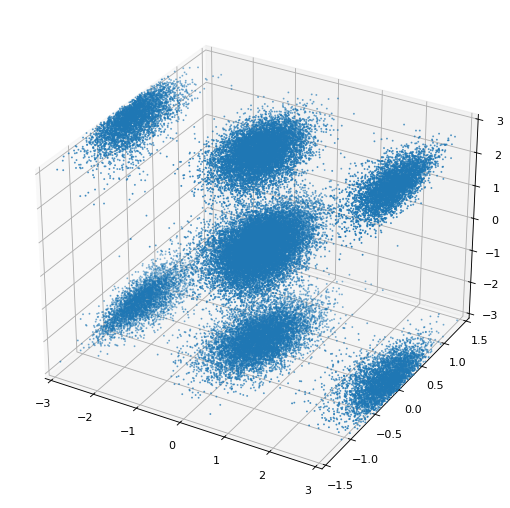

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load toy dataset
data = np.load('data/orthogonal_group.npy')
print('size of toy dataset: ', len(data))

fig = plot_so3(data)
plt.savefig('figs/so3_synthetic_data.png', dpi=300)
plt.show()

### Dataloader

In [6]:
# load data
trainset = SpecialOrthogonalGroup(split="train")
trainloader = DataLoader(
    trainset, batch_size=1024, shuffle=True, num_workers=0
)

valset = SpecialOrthogonalGroup(split="valid")
valloader = DataLoader(
    valset, batch_size=256, shuffle=False, num_workers=0
)

testset = SpecialOrthogonalGroup(split="test")
testloader = DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=0
)

### Stochastic OT CFM

This is a stochastic SO(3) OTCFM. 
The flow is calculated at a sample drawn an approximation of the conditional probability path: 

 $\hat{\rho}_t(\tilde{r}_t|r_0, r_1) = \mathcal{IG}_\mathrm{SO(3)}\Big(\tilde{r}_t; \exp_{r_0}(t \log_{r_0}(r_1)), \gamma^2(t) t(1-t)\Big)$

In [7]:
so3_group = SpecialOrthogonal(n=3, point_type="matrix")
FM = SO3SFM(manifold=so3_group) 

### Loss Functions

The final loss corresponds to equation (8) in the paper:

$$ \mathcal{L}_{\mathrm{sfm}-\mathrm{SO(3)}}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), \bar{\pi}(r_0, r_1), \rho_t(\tilde{r}_t | r_0, r_1)} \left \|v_\theta(t, \tilde{r}_t) - \log_{\tilde{r}_t}(r_0)/t \right\|_{\mathrm{SO(3)}}^2.$$

In [8]:
def cfm_loss(v1, v2, x):
    res = v1 - v2
    norm = norm_SO3(x, res)
    loss = torch.mean(norm, dim=-1)
    return loss

### SDE Inference

Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

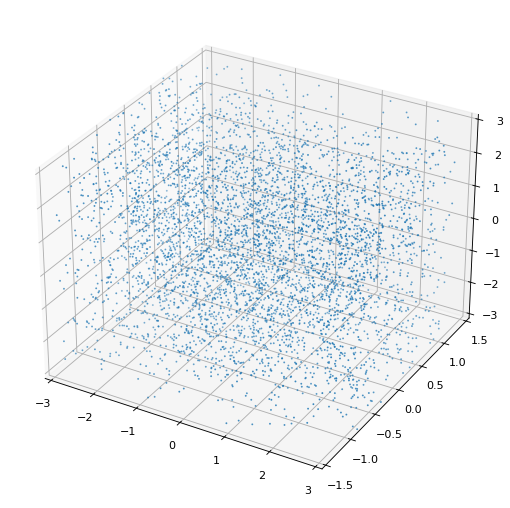

wassterstein-1 distance: 0.9599884048541742
wassterstein-2 distance: 1.1348735384041604


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

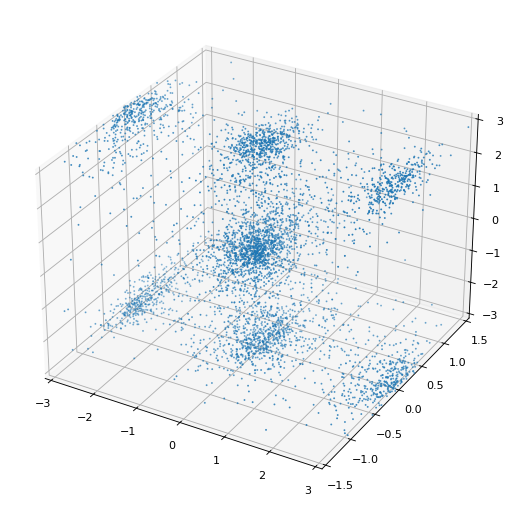

wassterstein-1 distance: 0.07065399523965898
wassterstein-2 distance: 0.14703908893672266


Epoch 10: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s, loss=0.513, step=439]


In [9]:
def sde_inference(vt, zt, dt):
    gt = FM.g
    dDet = vt * dt 
    # print(zt.dtype, dDet.dtype)
    zt_det = expmap(zt, dDet)

    noise_scale = 1.0
    noise = noise_scale * torch.randn(size=(vt.shape[0], 3), dtype=vt.dtype).to(device)
    dB = gt * torch.sqrt(dt) * noise 
    dB_skew_sym = hat(dB)
    zt_next = zt_det @ exp(dB_skew_sym)  
    
    # iden_mat = torch.eye(3).to(device)[None].repeat(vt.shape[0], 1, 1)
    # sigma = gt * torch.sqrt(dt).repeat(vt.shape[0])
    # dB = _batch_sample(iden_mat, sigma, 1)
    # zt_next = zt_det @ dB
    return zt_next

def inference(vfield_net, zt, t, dt):
    with torch.no_grad():
        # print('infer model dtype',list(vfield_net.parameters())[0].dtype)
        # print('data dtype',torch.cat([zt, t[:, None]], dim=-1).dtype)
        vt = vfield_net(torch.cat([zt, t[:, None]], dim=-1))
        vt = rearrange(vt, 'b (c d) -> b c d', c=3, d=3)
        zt = rearrange(zt, 'b (c d) -> b c d', c=3, d=3)
        zt_next = sde_inference(vt, zt, dt)       
        return rearrange(zt_next, 'b c d -> b (c d)', c=3, d=3).double()
dim = 9  # network ouput is 9 dimensional (3x3 matrix)

# MLP with a projection at the end, projection on to the tanget space of the manifold
vfield_net = PMLP(dim=dim, time_varying=True).to(device)
# print('init net dtype',list(vfield_net.parameters())[0].dtype)
optimizer = torch.optim.Adam(vfield_net.parameters(), lr=1e-3)
def main_loop(model, optimizer, num_epochs=150, display=True):
    losses = []
    w1ds = []
    w2ds = []

    global_step = 0
    for epoch in range(num_epochs):

        if display:
            progress_bar = tqdm(total=len(trainloader))
            progress_bar.set_description(f"Epoch {epoch}")

        if (epoch % 10) == 0:
            n_test = testset.data.shape[0]
            traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
            for t in torch.linspace(0, 1, 200):
                t = torch.tensor([t]).to(device).repeat(n_test).type_as(traj)
                dt = torch.tensor([1/200]).to(device)
                traj = inference(model, traj, t, dt)
            final_traj = rearrange(traj, 'b (c d) -> b c d', c=3, d=3)

            w_d1 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=1)
            w_d2 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=2)
            w1ds.append(w_d1)
            w2ds.append(w_d2)

            if display:
                plot_so3(final_traj)
                plt.show()
                print('wassterstein-1 distance:', w_d1)
                print('wassterstein-2 distance:', w_d2)


        for _, data in enumerate(trainloader):
            optimizer.zero_grad()
            x1 = data.to(device)
            x0 = torch.tensor(Rotation.random(x1.size(0)).as_matrix()).to(device)

            t, zt, ut = FM.sample_location_and_conditional_flow(x0, x1)

            vt = model(torch.cat([rearrange(zt, 'b c d -> b (c d)', c=3, d=3),
                                        t[:, None]], dim=-1))
            vt = rearrange(vt, 'b (c d) -> b c d', c=3, d=3)

            loss = cfm_loss(vt, ut, zt)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            if display:
                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "step": global_step}
                progress_bar.set_postfix(**logs)
                global_step += 1

    return model, np.array(losses), np.array(w1ds), np.array(w2ds)

vfield_net, losses, w1s, w2s = main_loop(vfield_net, optimizer, num_epochs=11, display=True)

### Results for Multiple Runs

In [ ]:
list(vfield_net.parameters())[0].dtype

In [ ]:
w1ds_runs = []
w2ds_runs = []
start_times_runs = []
losses_runs = []

num_runs = 5
for i in range(num_runs):
    print('doing run ', i)
    dim = 9
    vfield_net = PMLP(dim=dim, time_varying=True).to(device).double()
    # print('init net dtype',list(vfield_net.parameters())[0].dtype)
    optimizer = torch.optim.Adam(vfield_net.parameters(), lr=1e-3, weight_decay=1e-5)
    vfield_net, losses, w1ds, w2ds = main_loop(vfield_net, optimizer, num_epochs=80, display=False)

    w1ds_runs.append(w1ds)
    w2ds_runs.append(w2ds)
    losses_runs.append(losses)

losses_runs = np.array(losses_runs)
w1ds_runs = np.array(w1ds_runs)
w2ds_runs = np.array(w2ds_runs)

### Plot results

In [ ]:
# mean of w1s
w1s_mean = np.mean(w1ds_runs, axis=0)
w1s_std = np.std(w1ds_runs, axis=0)

# mean of w2s
w2s_mean = np.mean(w2ds_runs, axis=0)
w2s_std = np.std(w2ds_runs, axis=0)

In [ ]:
print('w1s_mean', w1s_mean[-1])
print('w1s_std', w1s_std[-1])
print('w2s_mean', w2s_mean[-1])
print('w2s_std', w2s_std[-1])

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

x = np.arange(0, 80, 10)

ax[0].plot(x, w1s_mean)
ax[0].fill_between(x, w1s_mean - w1s_std, w1s_mean + w1s_std, color='C0', alpha=0.4)
ax[0].set_xlabel('epoch', fontsize=14)
ax[0].set_ylabel('1-Wasserstein distance', fontsize=14)

ax[1].plot(x, w2s_mean)
ax[1].fill_between(x, w2s_mean - w2s_std, w2s_mean + w2s_std, color='C0', alpha=0.4)
ax[1].set_xlabel('epoch', fontsize=14)
ax[1].set_ylabel('2-Wasserstein-2 distance', fontsize=14)
plt.show()

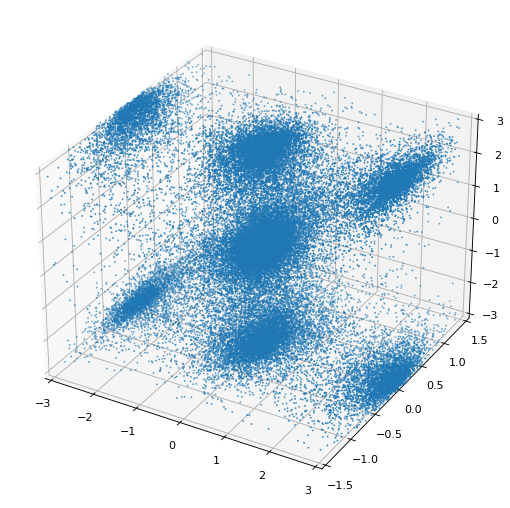

In [10]:
# inference on the full dataset for visualization
plt.style.use('default')
n_test = data.shape[0]
traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
for t in torch.linspace(0, 1, 200):
    t = torch.tensor([t]).to(device).repeat(n_test)
    dt = torch.tensor([1/200]).to(device)
    traj = inference(vfield_net, traj, t, dt)
final_traj = rearrange(traj, 'b (c d) -> b c d', c=3, d=3)
fig = plot_so3(final_traj)
plt.show()

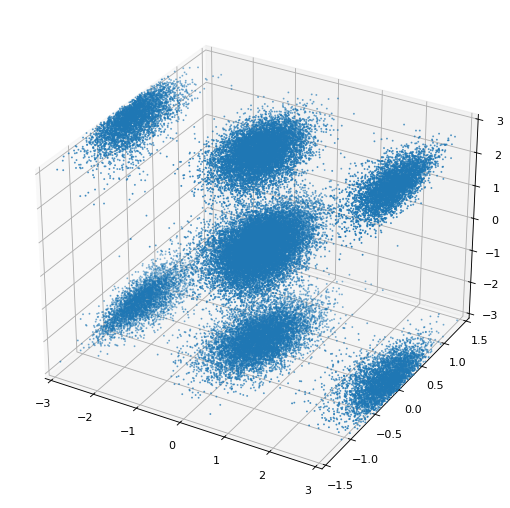

In [11]:
fig = plot_so3(data)